In [1]:
pip install pygam

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

In [6]:
# import os

cwd=os.getcwd

print(cwd)

<built-in function getcwd>


In [7]:
# Load dataset
Organ2 = pd.read_csv("/Users/meghana/Desktop/STAT/STAT409/STAT409Project/Data/Organ2.csv")

In [8]:

# Add ID and reshape dataframe
Organ2['ID'] = np.arange(1, Organ2.shape[0] + 1)
Organ2_long = Organ2.melt(id_vars=['ID', 'isBourdon', 'cutUpHeight', 'diameterToe', 'acousticIntensity'], 
                          value_vars=[col for col in Organ2.columns if "Partial" in col],
                          var_name="name_p", value_name="partial_value")

# Split 'name_p' column
Organ2_long['type'] = Organ2_long['name_p'].str.split("Partial").str[0]
Organ2_long['partial_num'] = Organ2_long['name_p'].str.split("Partial").str[1].astype(float)



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


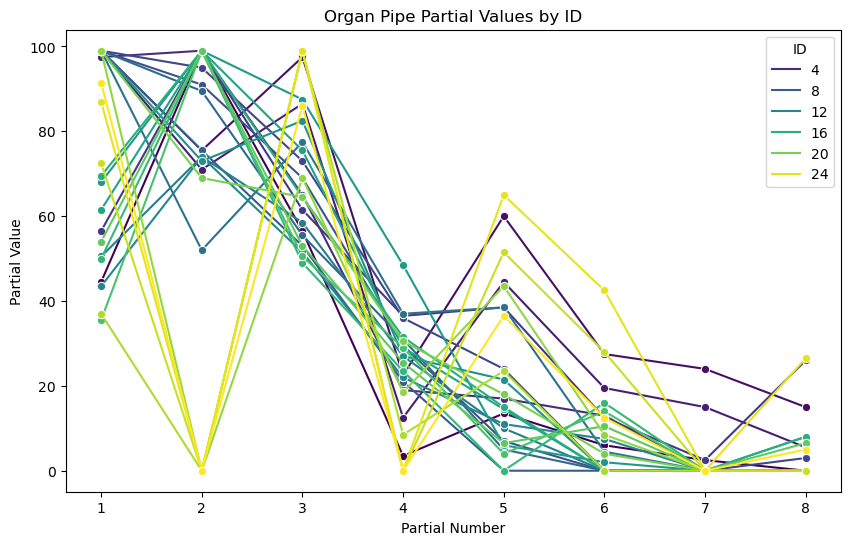

In [9]:
# Summarize data
summaryData = Organ2_long.groupby(['ID', 'partial_num', 'isBourdon', 'cutUpHeight', 'diameterToe', 'acousticIntensity'], 
                                  as_index=False)['partial_value'].mean()

# Plot data
plt.figure(figsize=(10,6))
sns.lineplot(data=summaryData, x='partial_num', y='partial_value', hue='ID', marker='o', palette='viridis')
plt.xlabel('Partial Number')
plt.ylabel('Partial Value')
plt.title('Organ Pipe Partial Values by ID')
plt.legend(title='ID')
plt.show()



In [10]:
# GAM modeling
X = summaryData[['partial_num']].values
y = summaryData['partial_value'].values

mod1 = LinearGAM(s(0, n_splines=5)).fit(X, y)
print(mod1.summary())




LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                        3.04
Link Function:                     IdentityLink Log Likelihood:                                 -1406.0902
Number of Samples:                          200 AIC:                                             2820.2604
                                                AICc:                                            2820.4693
                                                GCV:                                               463.183
                                                Scale:                                            450.5278
                                                Pseudo R-Squared:                                   0.6488
Feature Function                  Lam

/var/folders/f8/lp_yjvn94q3ft5xk_g5p3pb00000gp/T/ipykernel_6950/3620772777.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(mod1.summary())


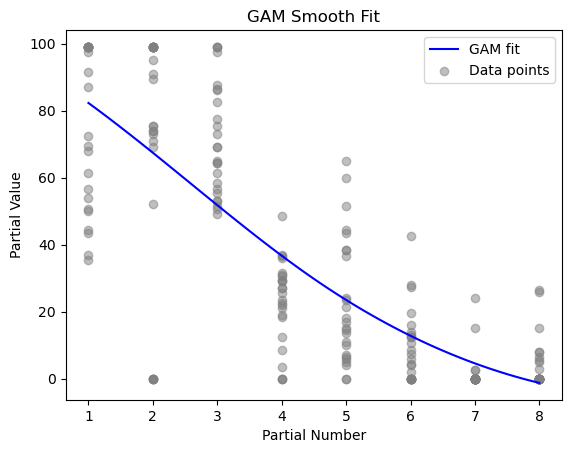

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: partial_value
No. Observations: 200     Method:             REML         
No. Groups:       25      Scale:              479.8049     
Min. group size:  8       Log-Likelihood:     -898.2418    
Max. group size:  8       Converged:          Yes          
Mean group size:  8.0                                      
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     89.855    3.414  26.323 0.000  83.165  96.545
partial_num  -12.253    0.676 -18.127 0.000 -13.578 -10.928
Group Var      0.000    1.168                              



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
# Plot GAM results
fig, ax = plt.subplots()
XX = mod1.generate_X_grid(term=0)
ax.plot(XX, mod1.predict(XX), color='blue', label='GAM fit')
ax.scatter(X, y, alpha=0.5, color='grey', label='Data points')
ax.set_xlabel('Partial Number')
ax.set_ylabel('Partial Value')
ax.set_title('GAM Smooth Fit')
ax.legend()
plt.show()

# Mixed Linear Model for Random Effects
summaryData['partial_num'] = summaryData['partial_num'].astype(float)
md = mixedlm("partial_value ~ partial_num", summaryData, groups=summaryData["ID"])
mdf = md.fit()
print(mdf.summary())